## 2. Data Loading, Preparation & Cleaning

In [1]:
# Importing all the libraries
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


## 2.1  Explore the Data

In [2]:
# Reading the data using pandas dataframe
features = pd.read_csv('features.csv.zip')
train = pd.read_csv('train.csv.zip')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv.zip')
sample_submission = pd.read_csv('train.csv.zip')

In [3]:
print(features.head())
print("------------------------------------------------------------\n")
print(stores.head())
print("------------------------------------------------------------\n")
print(train.head())
print("------------------------------------------------------------\n")
print(test.head())
print("------------------------------------------------------------\n")
print(sample_submission.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  
------------------------------------------------------------

   Store Type    Size
0      1    A  151315
1      2    A  202307
2

We can see that the test dataset don't contain the features included in the train dataset, taking into consideration that these features (Temperature, Fuel price, MarkDowns, CPI and Unemployment) cannot be used in the test dataset due to their high dependences on the date, so it will be a good idea to delete them. but before that, we will make sure that these features don't provide any information on the target 'Weekly_Sales'.

In [4]:
# Finding the number of rowns and columns in dataframe
features.shape, train.shape, stores.shape, test.shape

((8190, 12), (421570, 5), (45, 3), (115064, 4))

In [5]:
# Some basic information of differnt column's data type of dataframe
print(features.dtypes)
print("------------------------------------------------------------\n")
print(train.dtypes)
print("------------------------------------------------------------\n")
print(stores.dtypes)
print("------------------------------------------------------------\n")
print(test.dtypes)

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object
------------------------------------------------------------

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object
------------------------------------------------------------

Store     int64
Type     object
Size      int64
dtype: object
------------------------------------------------------------

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object


# Prepare the Dataset for Training

### 2.2 Data Cleaning
Let's start by cleaning the data of both datasets. We will see if they have missing values, duplicates and see if eliminate them if thats the case.

Very important to take into account that both datasets are going to merge. Therefore, they must have one key column that has the same values. Hence, We will also see if the values are consistent in both datasets.

In [6]:
feature_store = features.merge(stores, how='inner', on = "Store")

In [7]:
train = train.merge(feature_store, how='inner', on=['Store','Date','IsHoliday'])

In [8]:
test = test.merge(feature_store, how='inner', on=['Store','Date','IsHoliday'])

In [9]:
# Another useful step is to facilate the acces to the 'Date' attribute by splitting it into its componenents (i.e. Year, Month and week,day).
train = train.copy()
test = test.copy()

train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = pd.to_datetime(train['Date']).dt.year
train['Month'] = pd.to_datetime(train['Date']).dt.month
train['Week'] = pd.to_datetime(train['Date']).dt.week
train['Day'] = pd.to_datetime(train['Date']).dt.day
train.replace({'A': 1, 'B': 2,'C':3},inplace=True)

test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = pd.to_datetime(test['Date']).dt.year
test['Month'] = pd.to_datetime(test['Date']).dt.month
test['Week'] = pd.to_datetime(test['Date']).dt.week
test['Day'] = pd.to_datetime(test['Date']).dt.day
test.replace({'A': 1, 'B': 2,'C':3},inplace=True)


In [10]:
print(train.head())
print("------------------------------------------------------------\n")
print(test.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     2 2010-02-05      50605.27      False        42.31       2.572   
2      1     3 2010-02-05      13740.12      False        42.31       2.572   
3      1     4 2010-02-05      39954.04      False        42.31       2.572   
4      1     5 2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment  Type    Size  Year  Month  Week  Day  
0         8.106     1  151315  2010 

##  Descriptive statistics & data visualizations:
### Weekly_Sales
The plot makes the right skewness clear, so most weeks have sales around the median.
Also, we can see that the Weekly_Sales attribute has a large kurtosis which indicates the presence of extreme values, in other words, some weeks have high sales. It would be a good idea to know the origins of these extreme values.

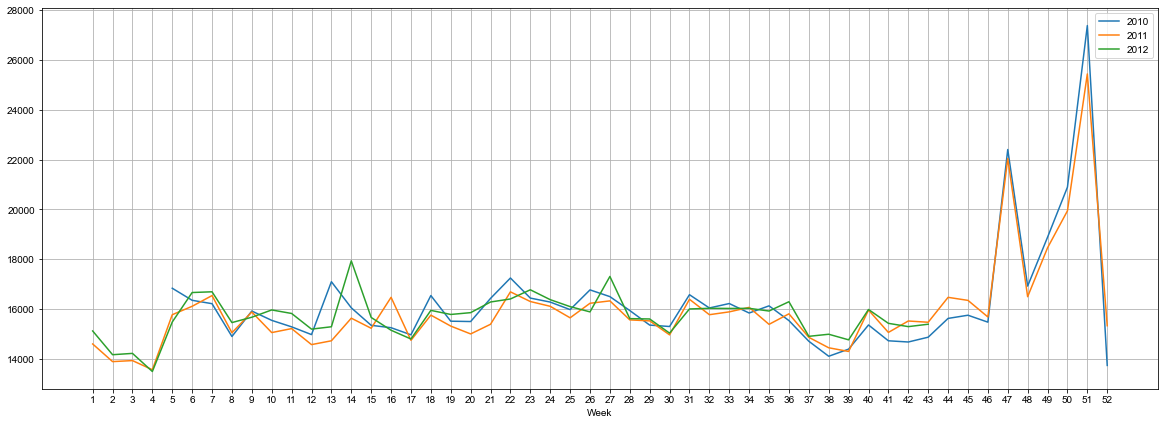

In [11]:
weekly_sales = train.groupby(['Year','Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train.loc[train['Year']==2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train.loc[train['Year']==2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = train.loc[train['Year']==2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
plt.figure(figsize=(20, 7))
sns.lineplot(weekly_sales2010['Weekly_Sales']['mean'].index, weekly_sales2010['Weekly_Sales']['mean'].values)
sns.lineplot(weekly_sales2011['Weekly_Sales']['mean'].index, weekly_sales2011['Weekly_Sales']['mean'].values)
sns.lineplot(weekly_sales2012['Weekly_Sales']['mean'].index, weekly_sales2012['Weekly_Sales']['mean'].values)

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'])
sns.set({'ytick.labelcolor':'white','xtick.labelcolor':'white'}) 
plt.show()

In [12]:
Y_train = train['Weekly_Sales']

In [13]:
targets = Y_train.copy()

In [14]:
train= train.drop(['Weekly_Sales'],axis=1)


In [15]:
# Let's also identify the numeric and categorical columns.
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train.select_dtypes('object').columns.tolist()

In [16]:
print(numeric_cols)
print("------------------------------------------------------------\n")
print(categorical_cols)

['Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year', 'Month', 'Week', 'Day']
------------------------------------------------------------

[]


In [17]:
# Check if there is any null value in train dataframe
train.isnull().sum()

Store                0
Dept                 0
Date                 0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Year                 0
Month                0
Week                 0
Day                  0
dtype: int64

In [18]:
# Check if there is any null value test in dataframe
test.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
Year                0
Month               0
Week                0
Day                 0
dtype: int64

# Impute Numerical Data

In [19]:
# Create the imputer
imputer = SimpleImputer(missing_values= np.NaN, strategy='mean')

In [20]:
# Fit the imputer to the numeric columns
imputer.fit(train[numeric_cols])

SimpleImputer()

In [21]:
#Replace all the null values
train[numeric_cols] =imputer.transform(train[numeric_cols])

In [22]:
# Check if there is any null value
train.isnull().sum()

Store           0
Dept            0
Date            0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Year            0
Month           0
Week            0
Day             0
dtype: int64

# Evaluate Algorithms
After analysing, cleaning and preparing the data, the next step is to select the best algorithm with the optimal parameters to obtain the best results.
This step requiers manually selecting the type of data normalization, manually selecting algorithms and tune all hyperparameters. 

Many algorithms assume normal distribution of the data, especially when features have different ranges like our case, so it is necessary to implement this step in our pipeline.

#### For data normalization, Lale will have the following choices :

1. MinMaxscaler
#### Algorithms used for spot-checking :

1. LinearRegression
2. RandomForestRegressor
3. GradientBoostingRegressor

In [23]:
# importing MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [24]:
# Create the scaler
scaler = MinMaxScaler()

In [25]:
# Fit the scaler to the numeric columns
scaler.fit(train[numeric_cols])

MinMaxScaler()

In [26]:
# Transform and replace the numeric columns
train[numeric_cols] = scaler.transform(train[numeric_cols])

In [27]:
train[numeric_cols].describe().loc[['min', 'max']]

,Store,Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week,Day
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
# 'Date' is irrelevant and Drop it from data.
train= train.drop(['Date'],axis=1)
test = test.drop(['Date'], axis=1)

In [29]:
# Preparing the dataset:
X_train =train[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
X_test = test[['Store', 'Dept','IsHoliday', 'Size', 'Week', 'Type', 'Year']]

In [30]:
print(X_train.columns)
print(X_test.columns)

Index(['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year'], dtype='object')
Index(['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year'], dtype='object')


# Training and Validation Set

In [31]:
# Splitting and training
train_inputs, val_inputs, train_targets, val_targets = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

# Make Predictions and Evaluate Your Model

## XGBRegressor

In [32]:
# importing XGBRegressor
from xgboost import XGBRegressor

In [33]:
# fitting the model
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [34]:
model.fit(train_inputs,train_targets)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

## Feature Importance
Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.


In [35]:
#Let's turn this into a dataframe and visualize the most important features.
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance':model.feature_importances_
}).sort_values('importance', ascending=False)

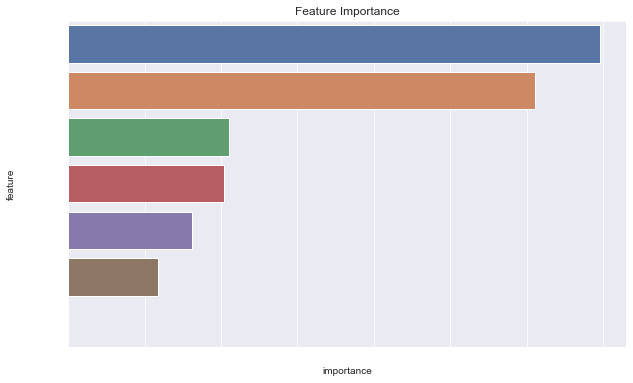

In [36]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [37]:
# Make and evaluate predictions:
x_pred = model.predict(train_inputs)
x_pred

array([ 3101.5615,  6328.4175,  3373.5718, ..., 55422.164 , 15274.511 ,
       21858.455 ], dtype=float32)

### Evaluation

In [38]:
# calculating mean_squared_error
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [39]:
rmse(x_pred,train_targets)

10943.379573724877

## Making Predictions

In [40]:
x_preds=model.predict(X_test)
x_preds

array([1990.9271, 1990.9271, 1990.9271, ..., 1990.9271, 1990.9271,
       1990.9271], dtype=float32)

In [41]:
Final = X_test[['Store', 'Dept', 'Week']]
test['Weekly_Sales']= x_preds

In [42]:
sample_submission['Weekly_Sales'] = test['Weekly_Sales']
sample_submission.to_csv('submission_2.csv',index=False)

In [43]:
preds1=pd.read_csv('submission_2.csv')

In [44]:
preds1['Id']=[x for x in range(1,421571)]
preds1

,Store,Dept,Date,Weekly_Sales,IsHoliday,Id
0,1,1,2010-02-05,1990.9271,False,1
1,1,1,2010-02-12,1990.9271,True,2
2,1,1,2010-02-19,1990.9271,False,3
3,1,1,2010-02-26,1990.9271,False,4
4,1,1,2010-03-05,1990.9271,False,5
...,...,...,...,...,...,...
421565,45,98,2012-09-28,NaN,False,421566
421566,45,98,2012-10-05,NaN,False,421567
421567,45,98,2012-10-12,NaN,False,421568
421568,45,98,2012-10-19,NaN,False,421569


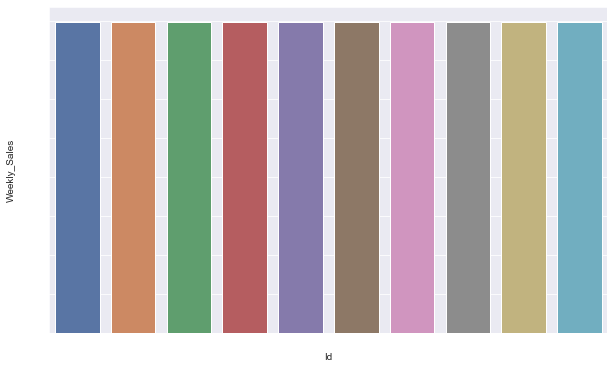

In [45]:
#ploting prediction
plt.figure(figsize=(10,6))
sns.barplot(data=preds1.head(10), x='Id', y='Weekly_Sales');

## RandomForestRegressor

## Hyperparameter Tuning
For hyperparameter tuning, Lale give us the choice to use its search space or schemas as is, or we can customize the schemas to fit our purposes

In [46]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [47]:
test_params(n_estimators=20, max_depth=20)

(1797.811385410645, 3434.4162052825986)

In [48]:
test_params(n_estimators=50, max_depth=10,min_samples_split=3, min_samples_leaf=4, max_features=0.4)

(13806.977338643439, 14212.377040662092)

#### To plot the graph between training error and validation error.

In [49]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [50]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

KeyboardInterrupt: 

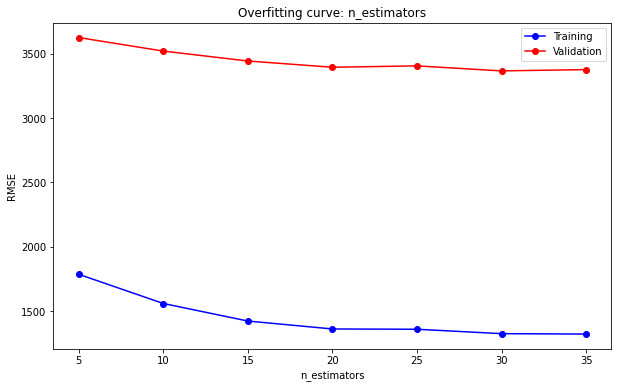

In [ ]:
test_param_and_plot('n_estimators', [5, 10, 15, 20, 25, 30, 35])

# Training the Best Model

In [ ]:
# fitting the model with Hyperparameter Overfitting 
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(train_inputs,train_targets)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

##### We can compute the accuracy of the model on the training and validation sets using RF.score

In [ ]:
RF.score(train_inputs, train_targets)

0.9952461366564544

In [ ]:
RF.score(val_inputs, val_targets)

0.977532756042686

In [ ]:
# Make and evaluate predictions:
train_preds = RF.predict(train_inputs)
train_preds

array([5.46240230e+00, 1.77197939e+03, 5.00463821e+02, ...,
       6.07127229e+04, 3.52100959e+04, 1.58871344e+04])

### Evaluation

In [ ]:
rmse(train_targets,train_preds)

1562.7416491322695

## Feature Importance
Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [ ]:
# Let's turn this into a dataframe and visualize the most important features.
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': RF.feature_importances_
}).sort_values('importance', ascending=False)

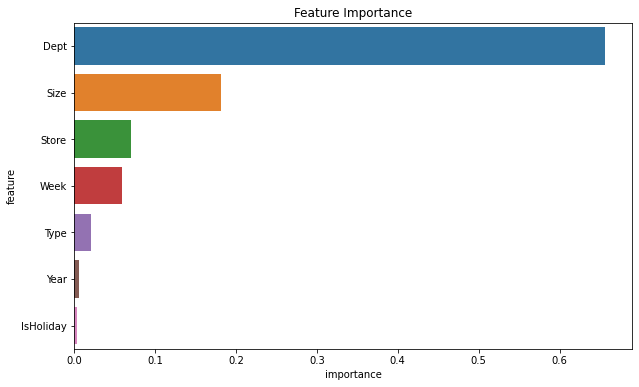

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

# Making Predictions

In [ ]:
predict = RF.predict(X_test)
predict

array([1764.72640805, 1764.72640805, 1764.72640805, ..., 1764.72640805,
       1764.72640805, 1764.72640805])

## Making Predictions

In [ ]:
Final = X_test[['Store', 'Dept', 'Week']]
test['Weekly_Sales']= predict

In [ ]:
predicts=pd.read_csv('submission.csv')
predicts['Id']=[x for x in range(1,421571)]
sample_submission['Weekly_Sales'] = test['Weekly_Sales']
sample_submission.to_csv('submission.csv',index=False)

predicts

,Store,Dept,Date,Weekly_Sales,IsHoliday,Id
0,1,1,2010-02-05,1365.83225,False,1
1,1,1,2010-02-12,1365.83225,True,2
2,1,1,2010-02-19,1365.83225,False,3
3,1,1,2010-02-26,1365.83225,False,4
4,1,1,2010-03-05,1365.83225,False,5
...,...,...,...,...,...,...
421565,45,98,2012-09-28,NaN,False,421566
421566,45,98,2012-10-05,NaN,False,421567
421567,45,98,2012-10-12,NaN,False,421568
421568,45,98,2012-10-19,NaN,False,421569


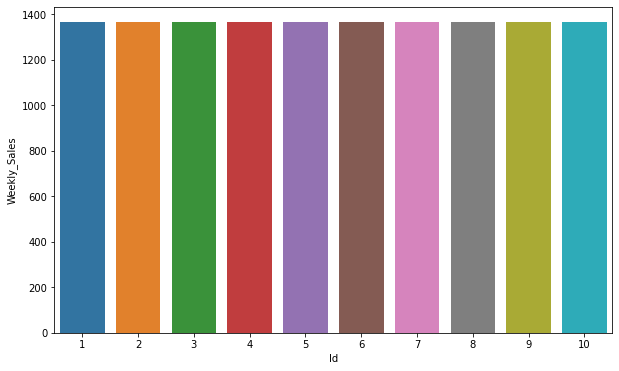

In [ ]:
#ploting prediction
plt.figure(figsize=(10,6))
sns.barplot(data=predicts.head(10), x='Id', y='Weekly_Sales');

## LinearRegression

In [ ]:
# importing the LinearRegression algorithm
from sklearn.linear_model import LinearRegression

In [ ]:
# fitting the model
lr=LinearRegression()
lr.fit(train_inputs,train_targets)

LinearRegression()

In [ ]:
Y_pred=lr.predict(train_inputs)
Y_pred

array([10511.43062391, 15878.69963478, 22838.38990493, ...,
       26901.83662411, 12732.32849333, 20548.72973757])

### Evaluation

In [ ]:
rmse(train_targets,Y_pred)

21674.949850452453

## Making Predictions

In [ ]:
y_pred=lr.predict(X_test)
y_pred

array([2.91715719e+09, 2.91716812e+09, 2.91717906e+09, ...,
       2.27987346e+09, 2.27989533e+09, 2.27990626e+09])

In [ ]:
weekly_sales

Weekly_Sales          
                   mean    median
Year Week                        
2010 5     16836.121997  7904.690
     6     16352.056032  8365.095
     7     16216.658979  8411.250
     8     14899.549688  7235.800
     9     15921.015727  7717.975
...                 ...       ...
2012 39    14765.327279  6957.120
     40    15983.413747  7486.845
     41    15427.596739  7324.960
     42    15295.732397  7374.700
     43    15391.725681  7547.230

[143 rows x 2 columns]

### To convert df to csv file

In [ ]:
Final = X_test[['Store', 'Dept', 'Week']]
test['Weekly_Sales']= y_pred

In [ ]:
sample_submission['Weekly_Sales'] = test['Weekly_Sales']
sample_submission.to_csv('submission_1.csv',index=False)

In [ ]:
preds=pd.read_csv('submission_1.csv')
preds
preds['Id']=[x for x in range(1,421571)]

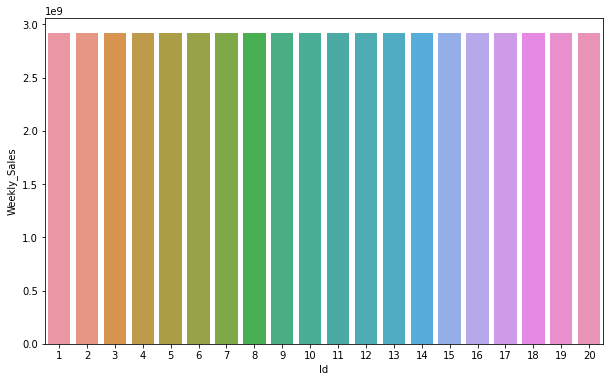

In [ ]:
#ploting prediction
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(data=preds.head(20),x='Id', y='Weekly_Sales');